In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif

In [ ]:
# Load the dataset
df = pd.read_csv("METABRIC_expression.csv") # Added parameters to handle errors and enforce engine
# Encode the target variable
print(df.columns)

# Split into features and target
X = df.iloc[:, :-1]  # All columns except the last
y = df.iloc[:, -1]   # Last colum

# Drop rows with missing values in the target variable
# This will remove corresponding rows from both X and y
data = pd.concat([X, y], axis=1).dropna(subset=[y.name])
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# --- Start of Suggested Changes ---
# Drop the 'Sample_ID' column as it's likely an identifier and not a feature
# Check if 'Sample_ID' exists in the columns of X before dropping
if 'Sample_ID' in X.columns:
    X = X.drop('Sample_ID', axis=1)
else:
    # If 'Sample_ID' is not in X, it might be in the original dataframe and not correctly excluded.
    # Inspect the dataframe columns to confirm which column contains the IDs.
    print("Warning: 'Sample_ID' column not found in features (X). Please check your data source.")

# --- End of Suggested Changes ---


# # Split dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


Index(['Sample_ID', 'brca1', 'brca2', 'palb2', 'pten', 'tp53', 'atm', 'cdh1',
       'chek2', 'nbn',
       ...
       'ppp2cb_mut', 'smarcd1_mut', 'nras_mut', 'ndfip1_mut', 'hras_mut',
       'prps2_mut', 'smarcb1_mut', 'stmn2_mut', 'siah1_mut', 'Label'],
      dtype='object', length=664)


<ipython-input-6-6faf3018bf0a>:2: DtypeWarning: Columns (490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("METABRIC_expression.csv") # Added parameters to handle errors and enforce engine


In [ ]:
#None + RF
# Initialize and train the Random Forest classifier

# --- Start of Suggested Changes ---
# Before fitting the model, ensure X_train contains only numerical or boolean types.
# Identify columns that are not numeric or boolean.
non_numeric_cols = X_train.select_dtypes(exclude=['number', 'bool']).columns

if len(non_numeric_cols) > 0:
    print(f"Non-numeric columns found in X_train: {list(non_numeric_cols)}")
    # Attempt to convert these columns.
    # A common scenario in METABRIC is mutation columns ending in '_mut' with string values.
    # We'll try to convert columns ending in '_mut' that are still objects.

    mut_columns_to_convert = [col for col in non_numeric_cols if col.endswith('_mut')]

    if len(mut_columns_to_convert) > 0:
        print(f"Attempting to convert mutation columns: {mut_columns_to_convert}")
        for col in mut_columns_to_convert:
            try:
                # Attempt to convert to boolean (assuming "True", "False", "0", "1", empty strings, etc.)
                # This handles various representations of binary states.
                X_train[col] = X_train[col].astype(bool)
                X_test[col] = X_test[col].astype(bool)
            except Exception as e:
                # If boolean conversion fails, try numeric (e.g., if some contain numbers)
                try:
                    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
                    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
                    # Fill potential NaNs introduced by 'coerce'
                    X_train[col] = X_train[col].fillna(0) # Or another appropriate strategy
                    X_test[col] = X_test[col].fillna(0)   # Or another appropriate strategy
                except Exception as e_numeric:
                     print(f"Warning: Could not convert column '{col}' to bool or numeric.")
                     print(f"Error details (bool): {e}")
                     print(f"Error details (numeric): {e_numeric}")
                     print(f"Unique values in '{col}': {X_train[col].unique()[:10]}...") # Show first 10 unique values
                     # If conversion fails, you might need to drop or one-hot encode
                     # For now, we'll leave it as is, which might lead to an error if not handled.
                     # A safer approach might be to drop it:
                     # X_train = X_train.drop(col, axis=1)
                     # X_test = X_test.drop(col, axis=1)
    else:
        print("No '_mut' columns found among non-numeric. Inspect other non-numeric columns.")
        print(f"Non-numeric columns remaining: {list(X_train.select_dtypes(exclude=['number', 'bool']).columns)}")
        # You might need to add code here to handle other types of non-numeric columns,
        # e.g., using pd.get_dummies() for other categorical columns.


# Verify dtypes after attempted conversion
print("\nDtypes after attempted conversion:")
print(X_train.dtypes.value_counts())
print("-" * 30)

# Drop any columns that still remain as 'object' dtype, as scikit-learn cannot handle them
object_cols_after = X_train.select_dtypes(include=['object']).columns
if len(object_cols_after) > 0:
    print(f"Dropping columns that are still 'object' dtype: {list(object_cols_after)}")
    X_train = X_train.drop(columns=object_cols_after)
    X_test = X_test.drop(columns=object_cols_after)
    print(f"Remaining dtypes after dropping objects:\n{X_train.dtypes.value_counts()}")


# --- End of Suggested Changes ---


rf = RandomForestClassifier(n_estimators=100, random_state=42)
# The fit method should now work as X_train should only contain numeric or boolean types
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)
# Ensure predict_proba output matches the expected shape for roc_auc_score
# For binary classification, it's (n_samples, 2). We need the probability of the positive class ([:, 1]).
# If y_train is multi-class after LabelEncoding, predict_proba will have shape (n_samples, n_classes).
# The original code assumes binary by taking [:, 1]. If multi-class, you might need
# to adjust roc_auc_score to use multi_class='ovr' or 'ovo' with the full probability array.
# Let's check y_train's unique values to be sure.
if len(np.unique(y_train)) <= 2:
    # Binary classification
    print("\nAssuming Binary Classification for AUC calculation.")
    y_pred_proba = rf.predict_proba(X_test)[:, 1]  # Probability estimates for AUC calculation (positive class)
else:
    # Multi-class classification
    print("\nAssuming Multi-class Classification for AUC calculation (using 'ovr').")
    y_pred_proba = rf.predict_proba(X_test) # Probability estimates for all classes
    # Note: Multi-class precision and AUC often require averaging strategies (e.g., 'weighted', 'macro', 'micro')
    # precision_score below is adjusted for potential multi-class. roc_auc_score will use 'ovr'.


# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
# Use weighted average for precision in case of multi-class classification
precision = precision_score(y_test, y_pred, average='weighted')

# Calculate AUC - Use 'ovr' strategy for multi-class if applicable, or default for binary
if len(np.unique(y_train)) <= 2:
     # Binary AUC
    auc = roc_auc_score(y_test, y_pred_proba)
else:
    # Multi-class AUC
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

kappa = cohen_kappa_score(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Kappa: {kappa:.4f}")

Non-numeric columns found in X_train: ['pik3ca_mut', 'tp53_mut', 'muc16_mut', 'ahnak2_mut', 'kmt2c_mut', 'syne1_mut', 'gata3_mut', 'map3k1_mut', 'ahnak_mut', 'dnah11_mut', 'cdh1_mut', 'dnah2_mut', 'kmt2d_mut', 'ush2a_mut', 'ryr2_mut', 'dnah5_mut', 'herc2_mut', 'pde4dip_mut', 'akap9_mut', 'tg_mut', 'birc6_mut', 'utrn_mut', 'tbx3_mut', 'col6a3_mut', 'arid1a_mut', 'lama2_mut', 'notch1_mut', 'cbfb_mut', 'ncor2_mut', 'col12a1_mut', 'col22a1_mut', 'pten_mut', 'akt1_mut', 'atr_mut', 'thada_mut', 'ncor1_mut', 'stab2_mut', 'myh9_mut', 'runx1_mut', 'nf1_mut', 'map2k4_mut', 'ros1_mut', 'lamb3_mut', 'arid1b_mut', 'erbb2_mut', 'sf3b1_mut', 'shank2_mut', 'ep300_mut', 'ptprd_mut', 'usp9x_mut', 'setd2_mut', 'setd1a_mut', 'thsd7a_mut', 'afdn_mut', 'erbb3_mut', 'rb1_mut', 'myo1a_mut', 'alk_mut', 'fanca_mut', 'adgra2_mut', 'ubr5_mut', 'pik3r1_mut', 'myo3a_mut', 'asxl2_mut', 'apc_mut', 'ctcf_mut', 'asxl1_mut', 'fancd2_mut', 'taf1_mut', 'kdm6a_mut', 'ctnna3_mut', 'brca1_mut', 'ptprm_mut', 'foxo3_mut', 'usp

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#None + LR
# Initialize and train the Random Forest classifier

# --- Start of Suggested Changes ---
# Before fitting the model, ensure X_train contains only numerical or boolean types.
# Identify columns that are not numeric or boolean.
non_numeric_cols = X_train.select_dtypes(exclude=['number', 'bool']).columns

if len(non_numeric_cols) > 0:
    print(f"Non-numeric columns found in X_train: {list(non_numeric_cols)}")
    # Attempt to convert these columns.
    # A common scenario in METABRIC is mutation columns ending in '_mut' with string values.
    # We'll try to convert columns ending in '_mut' that are still objects.

    mut_columns_to_convert = [col for col in non_numeric_cols if col.endswith('_mut')]

    if len(mut_columns_to_convert) > 0:
        print(f"Attempting to convert mutation columns: {mut_columns_to_convert}")
        for col in mut_columns_to_convert:
            try:
                # Attempt to convert to boolean (assuming "True", "False", "0", "1", empty strings, etc.)
                # This handles various representations of binary states.
                X_train[col] = X_train[col].astype(bool)
                X_test[col] = X_test[col].astype(bool)
            except Exception as e:
                # If boolean conversion fails, try numeric (e.g., if some contain numbers)
                try:
                    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
                    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
                    # Fill potential NaNs introduced by 'coerce'
                    X_train[col] = X_train[col].fillna(0) # Or another appropriate strategy
                    X_test[col] = X_test[col].fillna(0)   # Or another appropriate strategy
                except Exception as e_numeric:
                     print(f"Warning: Could not convert column '{col}' to bool or numeric.")
                     print(f"Error details (bool): {e}")
                     print(f"Error details (numeric): {e_numeric}")
                     print(f"Unique values in '{col}': {X_train[col].unique()[:10]}...") # Show first 10 unique values
                     # If conversion fails, you might need to drop or one-hot encode
                     # For now, we'll leave it as is, which might lead to an error if not handled.
                     # A safer approach might be to drop it:
                     # X_train = X_train.drop(col, axis=1)
                     # X_test = X_test.drop(col, axis=1)
    else:
        print("No '_mut' columns found among non-numeric. Inspect other non-numeric columns.")
        print(f"Non-numeric columns remaining: {list(X_train.select_dtypes(exclude=['number', 'bool']).columns)}")
        # You might need to add code here to handle other types of non-numeric columns,
        # e.g., using pd.get_dummies() for other categorical columns.


# Verify dtypes after attempted conversion
print("\nDtypes after attempted conversion:")
print(X_train.dtypes.value_counts())
print("-" * 30)

# Drop any columns that still remain as 'object' dtype, as scikit-learn cannot handle them
object_cols_after = X_train.select_dtypes(include=['object']).columns
if len(object_cols_after) > 0:
    print(f"Dropping columns that are still 'object' dtype: {list(object_cols_after)}")
    X_train = X_train.drop(columns=object_cols_after)
    X_test = X_test.drop(columns=object_cols_after)
    print(f"Remaining dtypes after dropping objects:\n{X_train.dtypes.value_counts()}")


# --- End of Suggested Changes ---

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Make predictions
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)[:, 1]  # Probability estimates for AUC calculation

# Ensure predict_proba output matches the expected shape for roc_auc_score
# For binary classification, it's (n_samples, 2). We need the probability of the positive class ([:, 1]).
# If y_train is multi-class after LabelEncoding, predict_proba will have shape (n_samples, n_classes).
# The original code assumes binary by taking [:, 1]. If multi-class, you might need
# to adjust roc_auc_score to use multi_class='ovr' or 'ovo' with the full probability array.
# Let's check y_train's unique values to be sure.
if len(np.unique(y_train)) <= 2:
    # Binary classification
    print("\nAssuming Binary Classification for AUC calculation.")
    y_pred_proba = lr.predict_proba(X_test)[:, 1]  # Probability estimates for AUC calculation (positive class)
else:
    # Multi-class classification
    print("\nAssuming Multi-class Classification for AUC calculation (using 'ovr').")
    y_pred_proba = lr.predict_proba(X_test) # Probability estimates for all classes
    # Note: Multi-class precision and AUC often require averaging strategies (e.g., 'weighted', 'macro', 'micro')
    # precision_score below is adjusted for potential multi-class. roc_auc_score will use 'ovr'.


# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
# Use weighted average for precision in case of multi-class classification
precision = precision_score(y_test, y_pred, average='weighted')

# Calculate AUC - Use 'ovr' strategy for multi-class if applicable, or default for binary
if len(np.unique(y_train)) <= 2:
     # Binary AUC
    auc = roc_auc_score(y_test, y_pred_proba)
else:
    # Multi-class AUC
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

kappa = cohen_kappa_score(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Kappa: {kappa:.4f}")


Dtypes after attempted conversion:
float64    489
bool       173
Name: count, dtype: int64
------------------------------

Assuming Multi-class Classification for AUC calculation (using 'ovr').
Accuracy: 0.7448
Precision: 0.7439
AUC: 0.9209
Kappa: 0.6683


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#None + SVM
# Initialize and train the Random Forest classifier

# --- Start of Suggested Changes ---
# Before fitting the model, ensure X_train contains only numerical or boolean types.
# Identify columns that are not numeric or boolean.
non_numeric_cols = X_train.select_dtypes(exclude=['number', 'bool']).columns

if len(non_numeric_cols) > 0:
    print(f"Non-numeric columns found in X_train: {list(non_numeric_cols)}")
    # Attempt to convert these columns.
    # A common scenario in METABRIC is mutation columns ending in '_mut' with string values.
    # We'll try to convert columns ending in '_mut' that are still objects.

    mut_columns_to_convert = [col for col in non_numeric_cols if col.endswith('_mut')]

    if len(mut_columns_to_convert) > 0:
        print(f"Attempting to convert mutation columns: {mut_columns_to_convert}")
        for col in mut_columns_to_convert:
            try:
                # Attempt to convert to boolean (assuming "True", "False", "0", "1", empty strings, etc.)
                # This handles various representations of binary states.
                X_train[col] = X_train[col].astype(bool)
                X_test[col] = X_test[col].astype(bool)
            except Exception as e:
                # If boolean conversion fails, try numeric (e.g., if some contain numbers)
                try:
                    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
                    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
                    # Fill potential NaNs introduced by 'coerce'
                    X_train[col] = X_train[col].fillna(0) # Or another appropriate strategy
                    X_test[col] = X_test[col].fillna(0)   # Or another appropriate strategy
                except Exception as e_numeric:
                     print(f"Warning: Could not convert column '{col}' to bool or numeric.")
                     print(f"Error details (bool): {e}")
                     print(f"Error details (numeric): {e_numeric}")
                     print(f"Unique values in '{col}': {X_train[col].unique()[:10]}...") # Show first 10 unique values
                     # If conversion fails, you might need to drop or one-hot encode
                     # For now, we'll leave it as is, which might lead to an error if not handled.
                     # A safer approach might be to drop it:
                     # X_train = X_train.drop(col, axis=1)
                     # X_test = X_test.drop(col, axis=1)
    else:
        print("No '_mut' columns found among non-numeric. Inspect other non-numeric columns.")
        print(f"Non-numeric columns remaining: {list(X_train.select_dtypes(exclude=['number', 'bool']).columns)}")
        # You might need to add code here to handle other types of non-numeric columns,
        # e.g., using pd.get_dummies() for other categorical columns.


# Verify dtypes after attempted conversion
print("\nDtypes after attempted conversion:")
print(X_train.dtypes.value_counts())
print("-" * 30)

# Drop any columns that still remain as 'object' dtype, as scikit-learn cannot handle them
object_cols_after = X_train.select_dtypes(include=['object']).columns
if len(object_cols_after) > 0:
    print(f"Dropping columns that are still 'object' dtype: {list(object_cols_after)}")
    X_train = X_train.drop(columns=object_cols_after)
    X_test = X_test.drop(columns=object_cols_after)
    print(f"Remaining dtypes after dropping objects:\n{X_train.dtypes.value_counts()}")


# --- End of Suggested Changes ---
svm_clf = SVC(kernel='rbf', probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

# Make predictions
y_pred = svm_clf.predict(X_test)
y_pred_proba = svm_clf.predict_proba(X_test)[:, 1]  # Probability estimates for AUC calculation


# Ensure predict_proba output matches the expected shape for roc_auc_score
# For binary classification, it's (n_samples, 2). We need the probability of the positive class ([:, 1]).
# If y_train is multi-class after LabelEncoding, predict_proba will have shape (n_samples, n_classes).
# The original code assumes binary by taking [:, 1]. If multi-class, you might need
# to adjust roc_auc_score to use multi_class='ovr' or 'ovo' with the full probability array.
# Let's check y_train's unique values to be sure.
if len(np.unique(y_train)) <= 2:
    # Binary classification
    print("\nAssuming Binary Classification for AUC calculation.")
    y_pred_proba = svm_clf.predict_proba(X_test)[:, 1]  # Probability estimates for AUC calculation (positive class)
else:
    # Multi-class classification
    print("\nAssuming Multi-class Classification for AUC calculation (using 'ovr').")
    y_pred_proba = svm_clf.predict_proba(X_test) # Probability estimates for all classes
    # Note: Multi-class precision and AUC often require averaging strategies (e.g., 'weighted', 'macro', 'micro')
    # precision_score below is adjusted for potential multi-class. roc_auc_score will use 'ovr'.


# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
# Use weighted average for precision in case of multi-class classification
precision = precision_score(y_test, y_pred, average='weighted')

# Calculate AUC - Use 'ovr' strategy for multi-class if applicable, or default for binary
if len(np.unique(y_train)) <= 2:
     # Binary AUC
    auc = roc_auc_score(y_test, y_pred_proba)
else:
    # Multi-class AUC
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

kappa = cohen_kappa_score(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Kappa: {kappa:.4f}")


Dtypes after attempted conversion:
float64    489
bool       173
Name: count, dtype: int64
------------------------------

Assuming Multi-class Classification for AUC calculation (using 'ovr').
Accuracy: 0.7605
Precision: 0.7576
AUC: 0.9308
Kappa: 0.6835


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#XGB + SVM
# Load the dataset
df = pd.read_csv("/content/sample_data/METABRIC_expression.csv") # Added parameters to handle errors and enforce engine
# Encode the target variable
print(df.columns)

# Split into features and target
X = df.iloc[:, :-1]  # All columns except the last
y = df.iloc[:, -1]   # Last column

# Drop rows with missing values in the target variable
# This will remove corresponding rows from both X and y
data = pd.concat([X, y], axis=1).dropna(subset=[y.name])
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# --- Start of Suggested Changes ---
# Drop the 'Sample_ID' column as it's likely an identifier and not a feature
if 'Sample_ID' in X.columns:
    X = X.drop('Sample_ID', axis=1)

# Identify columns ending with '_mut' that are of object dtype
mut_columns = [col for col in X.columns if col.endswith('_mut') and X[col].dtype == 'object']

# Convert these columns to boolean or integer type
# We'll try converting to boolean first, assuming "True"/"False" or similar representations.
# If this fails, inspect the data to see the actual string values and decide on conversion.
for col in mut_columns:
    try:
        # Attempt to convert to boolean (assuming values like "True", "False", "1", "0", "", etc.)
        # Coerce errors will turn unparseable values into NaT for boolean, or NaN for numeric.
        # You might need a more specific conversion based on the actual data content.
        X[col] = X[col].astype(bool)
    except ValueError:
        # If boolean conversion fails, try converting to numeric (int or float)
        try:
            X[col] = pd.to_numeric(X[col], errors='coerce')
            # If conversion to numeric results in NaNs for some rows,
            # you might need to decide how to handle them (e.g., fillna, drop rows).
            # For simplicity here, we will just proceed.
            # You might want to convert floats to int if appropriate (e.g., 0.0, 1.0)
            # X[col] = X[col].astype(int, errors='ignore') # Use errors='ignore' if conversion to int might fail
        except ValueError:
             # If numeric conversion also fails, the column contains non-numeric strings
             # that aren't directly interpretable as booleans.
             # Inspect these columns (e.g., print(X[col].unique())) to understand their content.
             # For now, we will leave them as object and they will be excluded or cause issues
             # if not handled further. A better approach is to encode them.
             print(f"Warning: Column '{col}' could not be converted to bool or numeric. It remains as object.")
             # Alternatively, you could drop these problematic columns:
             # X = X.drop(col, axis=1)


# --- End of Suggested Changes ---


# Use LabelEncoder to transform the target variable to be zero-indexed
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


# # Split dataset into training and testing sets (80-20 split)
# Use the encoded target variable for splitting
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

#XGB + SVM
# Train XGBoost to get feature importances
xgb_selector = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6,
                             subsample=0.8, colsample_bytree=0.8, random_state=42,
                             use_label_encoder=False, eval_metric="logloss")

# The fit method should now work as X_train should only contain numeric or boolean types
xgb_selector.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.Series(xgb_selector.feature_importances_, index=X.columns)

# List of feature selection counts
feature_counts = [10, 50, 100, 500, 1000]

# Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=["Features", "AUC", "Accuracy", "Precision", "Kappa"])

# Loop through different feature counts
for num_features in feature_counts:
    # Select top N features
    top_features = feature_importances.nlargest(num_features).index.tolist()

    # Filter dataset with selected features
    X_train_selected = X_train[top_features]
    X_test_selected = X_test[top_features]

    # Standardize the features (important for SVM)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    # Train SVM classifier
    # Note: SVM also requires zero-indexed labels, which are provided by y_train after LabelEncoding
    svm_clf = SVC(kernel="rbf", C=1.0, probability=True, random_state=42)
    svm_clf.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = svm_clf.predict(X_test_scaled)
    # When predicting probabilities for multi-class classification with SVM,
    # predict_proba returns an array of shape (n_samples, n_classes).
    # We need to calculate AUC per class or use a multi-class AUC metric.
    # For simplicity and to match the original structure aiming for a single AUC value,
    # we'll assume the problem might be treated as binary or we need a macro/micro AUC.
    # If this is a true multi-class problem, consider using metrics like
    # roc_auc_score(y_test, y_pred_proba, multi_class='ovr') or 'ovo'
    # For now, keeping the original approach which might be intended for binary or
    # the last column's probability in a multi-class context (less common for multi-class AUC).
    # If your problem is binary, this is correct. If multi-class, this line might need adjustment
    # based on how you want to calculate AUC. Assuming binary for now or a specific class's AUC.
    # To be safe for multi-class, you might need to adjust how AUC is calculated or the metric used.
    # Let's adjust to handle multi-class AUC correctly using 'ovr'
    y_pred_proba = svm_clf.predict_proba(X_test_scaled)

    # Evaluate model performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted') # Use weighted average for multi-class precision
    # Calculate multi-class AUC using 'ovr' (One-vs-Rest) strategy
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    kappa = cohen_kappa_score(y_test, y_pred)

    # Store results in DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([[num_features, auc, accuracy, precision, kappa]],
                                                      columns=["Features", "AUC", "Accuracy", "Precision", "Kappa"])],
                                                      ignore_index=True)

# Display final results
print(results_df)



<ipython-input-14-67b1662e47db>:2: DtypeWarning: Columns (490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/sample_data/METABRIC_expression.csv") # Added parameters to handle errors and enforce engine


Index(['Sample_ID', 'brca1', 'brca2', 'palb2', 'pten', 'tp53', 'atm', 'cdh1',
       'chek2', 'nbn',
       ...
       'ppp2cb_mut', 'smarcd1_mut', 'nras_mut', 'ndfip1_mut', 'hras_mut',
       'prps2_mut', 'smarcb1_mut', 'stmn2_mut', 'siah1_mut', 'Label'],
      dtype='object', length=664)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:09:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-14-67b1662e47db>:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([[num_features, auc, accuracy, precision, kappa]],
/usr/local/lib/python3.11/dist-package

  Features       AUC  Accuracy  Precision     Kappa
0       10  0.928545  0.725524   0.716584  0.635917
1       50  0.924326  0.755245   0.751892  0.679203
2      100  0.926632  0.758741   0.756745  0.682358
3      500  0.926623  0.753497   0.750595  0.674139
4     1000  0.924489  0.756993   0.753743  0.678675


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#XGB + LR
# Load the dataset
df = pd.read_csv("/content/sample_data/METABRIC_expression.csv") # Added parameters to handle errors and enforce engine
# Encode the target variable
print(df.columns)

# Split into features and target
X = df.iloc[:, :-1]  # All columns except the last
y = df.iloc[:, -1]   # Last column

# Drop rows with missing values in the target variable
# This will remove corresponding rows from both X and y
data = pd.concat([X, y], axis=1).dropna(subset=[y.name])
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# --- Start of Suggested Changes ---
# Drop the 'Sample_ID' column as it's likely an identifier and not a feature
if 'Sample_ID' in X.columns:
    X = X.drop('Sample_ID', axis=1)

# Identify columns ending with '_mut' that are of object dtype
mut_columns = [col for col in X.columns if col.endswith('_mut') and X[col].dtype == 'object']

# Convert these columns to boolean or integer type
# We'll try converting to boolean first, assuming "True"/"False" or similar representations.
# If this fails, inspect the data to see the actual string values and decide on conversion.
for col in mut_columns:
    try:
        # Attempt to convert to boolean (assuming values like "True", "False", "1", "0", "", etc.)
        # Coerce errors will turn unparseable values into NaT for boolean, or NaN for numeric.
        # You might need a more specific conversion based on the actual data content.
        X[col] = X[col].astype(bool)
    except ValueError:
        # If boolean conversion fails, try converting to numeric (int or float)
        try:
            X[col] = pd.to_numeric(X[col], errors='coerce')
            # If conversion to numeric results in NaNs for some rows,
            # you might need to decide how to handle them (e.g., fillna, drop rows).
            # For simplicity here, we will just proceed.
            # You might want to convert floats to int if appropriate (e.g., 0.0, 1.0)
            # X[col] = X[col].astype(int, errors='ignore') # Use errors='ignore' if conversion to int might fail
        except ValueError:
             # If numeric conversion also fails, the column contains non-numeric strings
             # that aren't directly interpretable as booleans.
             # Inspect these columns (e.g., print(X[col].unique())) to understand their content.
             # For now, we will leave them as object and they will be excluded or cause issues
             # if not handled further. A better approach is to encode them.
             print(f"Warning: Column '{col}' could not be converted to bool or numeric. It remains as object.")
             # Alternatively, you could drop these problematic columns:
             # X = X.drop(col, axis=1)


# --- End of Suggested Changes ---


# Use LabelEncoder to transform the target variable to be zero-indexed
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


# # Split dataset into training and testing sets (80-20 split)
# Use the encoded target variable for splitting
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

#XGB + SVM
# Train XGBoost to get feature importances
xgb_selector = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6,
                             subsample=0.8, colsample_bytree=0.8, random_state=42,
                             use_label_encoder=False, eval_metric="logloss")

# The fit method should now work as X_train should only contain numeric or boolean types
xgb_selector.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.Series(xgb_selector.feature_importances_, index=X.columns)

# List of feature selection counts
feature_counts = [10, 50, 100, 500, 1000]

# Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=["Features", "AUC", "Accuracy", "Precision", "Kappa"])

# Loop through different feature counts
for num_features in feature_counts:
    # Select top N features
    top_features = feature_importances.nlargest(num_features).index.tolist()

    # Filter dataset with selected features
    X_train_selected = X_train[top_features]
    X_test_selected = X_test[top_features]

    # Standardize the features (important for SVM)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    # Train SVM classifier
    # Note: SVM also requires zero-indexed labels, which are provided by y_train after LabelEncoding
    #svm_clf = SVC(kernel="rbf", C=1.0, probability=True, random_state=42)
    #svm_clf.fit(X_train_scaled, y_train)

    # Make predictions
    #y_pred = svm_clf.predict(X_test_scaled)
    # When predicting probabilities for multi-class classification with SVM,
    # predict_proba returns an array of shape (n_samples, n_classes).
    # We need to calculate AUC per class or use a multi-class AUC metric.
    # For simplicity and to match the original structure aiming for a single AUC value,
    # we'll assume the problem might be treated as binary or we need a macro/micro AUC.
    # If this is a true multi-class problem, consider using metrics like
    # roc_auc_score(y_test, y_pred_proba, multi_class='ovr') or 'ovo'
    # For now, keeping the original approach which might be intended for binary or
    # the last column's probability in a multi-class context (less common for multi-class AUC).
    # If your problem is binary, this is correct. If multi-class, this line might need adjustment
    # based on how you want to calculate AUC. Assuming binary for now or a specific class's AUC.
    # To be safe for multi-class, you might need to adjust how AUC is calculated or the metric used.
    # Let's adjust to handle multi-class AUC correctly using 'ovr'
    #y_pred_proba = svm_clf.predict_proba(X_test_scaled)
    lr_clf = LogisticRegression(solver="liblinear", C=1.0, random_state=42)
    lr_clf.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = lr_clf.predict(X_test_scaled)
    # Get the full probability array for AUC calculation
    y_pred_proba = lr_clf.predict_proba(X_test_scaled)

    # Evaluate model performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted') # Use weighted average for multi-class precision
    # Calculate multi-class AUC using 'ovr' (One-vs-Rest) strategy
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    kappa = cohen_kappa_score(y_test, y_pred)

    # Store results in DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([[num_features, auc, accuracy, precision, kappa]],
                                                      columns=["Features", "AUC", "Accuracy", "Precision", "Kappa"])],
                                                      ignore_index=True)

# Display final results
print(results_df)

<ipython-input-21-00d03fd6c98f>:3: DtypeWarning: Columns (490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/sample_data/METABRIC_expression.csv") # Added parameters to handle errors and enforce engine


Index(['Sample_ID', 'brca1', 'brca2', 'palb2', 'pten', 'tp53', 'atm', 'cdh1',
       'chek2', 'nbn',
       ...
       'ppp2cb_mut', 'smarcd1_mut', 'nras_mut', 'ndfip1_mut', 'hras_mut',
       'prps2_mut', 'smarcb1_mut', 'stmn2_mut', 'siah1_mut', 'Label'],
      dtype='object', length=664)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:56:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-21-00d03fd6c98f>:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([[num_features, auc, accuracy, precision, kappa]],
/usr/local/lib/python3.11/dist-package

  Features       AUC  Accuracy  Precision     Kappa
0       10  0.908941  0.725524   0.725784  0.635314
1       50  0.894732  0.718531   0.716973  0.631136
2      100  0.923582  0.730769   0.724635  0.647876
3      500  0.881048  0.655594   0.658928  0.554946
4     1000  0.880391  0.657343   0.660928  0.557069


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#XGB + RF
#Load the dataset
df = pd.read_csv("/content/sample_data/METABRIC_expression.csv") # Added parameters to handle errors and enforce engine
# Encode the target variable
print(df.columns)

# Split into features and target
X = df.iloc[:, :-1]  # All columns except the last
y = df.iloc[:, -1]   # Last column

# Drop rows with missing values in the target variable
# This will remove corresponding rows from both X and y
data = pd.concat([X, y], axis=1).dropna(subset=[y.name])
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# --- Start of Suggested Changes ---
# Drop the 'Sample_ID' column as it's likely an identifier and not a feature
if 'Sample_ID' in X.columns:
    X = X.drop('Sample_ID', axis=1)

# Identify columns ending with '_mut' that are of object dtype
mut_columns = [col for col in X.columns if col.endswith('_mut') and X[col].dtype == 'object']

# Convert these columns to boolean or integer type
# We'll try converting to boolean first, assuming "True"/"False" or similar representations.
# If this fails, inspect the data to see the actual string values and decide on conversion.
for col in mut_columns:
    try:
        # Attempt to convert to boolean (assuming values like "True", "False", "1", "0", "", etc.)
        # Coerce errors will turn unparseable values into NaT for boolean, or NaN for numeric.
        # You might need a more specific conversion based on the actual data content.
        X[col] = X[col].astype(bool)
    except ValueError:
        # If boolean conversion fails, try converting to numeric (int or float)
        try:
            X[col] = pd.to_numeric(X[col], errors='coerce')
            # If conversion to numeric results in NaNs for some rows,
            # you might need to decide how to handle them (e.g., fillna, drop rows).
            # For simplicity here, we will just proceed.
            # You might want to convert floats to int if appropriate (e.g., 0.0, 1.0)
            # X[col] = X[col].astype(int, errors='ignore') # Use errors='ignore' if conversion to int might fail
        except ValueError:
             # If numeric conversion also fails, the column contains non-numeric strings
             # that aren't directly interpretable as booleans.
             # Inspect these columns (e.g., print(X[col].unique())) to understand their content.
             # For now, we will leave them as object and they will be excluded or cause issues
             # if not handled further. A better approach is to encode them.
             print(f"Warning: Column '{col}' could not be converted to bool or numeric. It remains as object.")
             # Alternatively, you could drop these problematic columns:
             # X = X.drop(col, axis=1)


# --- End of Suggested Changes ---


# Use LabelEncoder to transform the target variable to be zero-indexed
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


# # Split dataset into training and testing sets (80-20 split)
# Use the encoded target variable for splitting
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

#XGB + RF
# Train XGBoost to get feature importances
xgb_selector = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6,
                             subsample=0.8, colsample_bytree=0.8, random_state=42,
                             use_label_encoder=False, eval_metric="logloss")

# The fit method should now work as X_train should only contain numeric or boolean types
xgb_selector.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.Series(xgb_selector.feature_importances_, index=X.columns)

# List of feature selection counts
feature_counts = [10, 50, 100, 500, 1000]

# Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=["Features", "AUC", "Accuracy", "Precision", "Kappa"])

# Loop through different feature counts
for num_features in feature_counts:
    # Select top N features
    top_features = feature_importances.nlargest(num_features).index.tolist()

    # Filter dataset with selected features
    X_train_selected = X_train[top_features]
    X_test_selected = X_test[top_features]

    # Standardize the features (important for SVM)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    # Train Random Forest classifier
    rf_clf = RandomForestClassifier(n_estimators=500, max_depth=None, min_samples_split=2,
                                    random_state=42, n_jobs=-1)
    rf_clf.fit(X_train_selected, y_train)

    # Make predictions
    y_pred = rf_clf.predict(X_test_selected)
    # Get the full probability array for AUC calculation (needed for multi_class='ovr')
    y_pred_proba = rf_clf.predict_proba(X_test_selected)

    # Evaluate model performance
    accuracy = accuracy_score(y_test, y_pred)
    # Use weighted average for multi-class precision
    precision = precision_score(y_test, y_pred, average='weighted')
    # Calculate multi-class AUC using 'ovr' (One-vs-Rest) strategy
    # Ensure y_test and y_pred_proba are correctly formatted for multi-class AUC
    # y_test should be the true labels (integers), y_pred_proba should be the probability array
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    kappa = cohen_kappa_score(y_test, y_pred)

    # Store results in DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([[num_features, auc, accuracy, precision, kappa]],
                                                      columns=["Features", "AUC", "Accuracy", "Precision", "Kappa"])],
                                                      ignore_index=True)

# Display final results
print(results_df)

<ipython-input-17-acc00c268bf3>:3: DtypeWarning: Columns (490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/sample_data/METABRIC_expression.csv") # Added parameters to handle errors and enforce engine


Index(['Sample_ID', 'brca1', 'brca2', 'palb2', 'pten', 'tp53', 'atm', 'cdh1',
       'chek2', 'nbn',
       ...
       'ppp2cb_mut', 'smarcd1_mut', 'nras_mut', 'ndfip1_mut', 'hras_mut',
       'prps2_mut', 'smarcb1_mut', 'stmn2_mut', 'siah1_mut', 'Label'],
      dtype='object', length=664)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:45:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-17-acc00c268bf3>:119: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([[num_features, auc, accuracy, precision, kappa]],
/usr/local/lib/python3.11/dist-package

  Features       AUC  Accuracy  Precision     Kappa
0       10  0.885932  0.730769   0.723480  0.644517
1       50  0.895673  0.755245   0.750002  0.675813
2      100  0.903263  0.760490   0.754832  0.682428
3      500  0.908160  0.762238   0.763888  0.682048
4     1000  0.923845  0.776224   0.778822  0.701593


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
df1 = pd.read_csv("metabric_clinical.csv")

In [ ]:
print(df1)

      Sample_ID  Age at Diagnosis Type of Breast Surgery    Cancer Type  \
0       MB-0000             75.65             Mastectomy  Breast Cancer   
1       MB-0002             43.19      Breast Conserving  Breast Cancer   
2       MB-0005             48.87             Mastectomy  Breast Cancer   
3       MB-0006             47.68             Mastectomy  Breast Cancer   
4       MB-0008             76.97             Mastectomy  Breast Cancer   
...         ...               ...                    ...            ...   
2504  MTS-T2428             70.05                    NaN  Breast Cancer   
2505  MTS-T2429             63.60                    NaN  Breast Cancer   
2506  MTS-T2430               NaN                    NaN  Breast Cancer   
2507  MTS-T2431               NaN                    NaN  Breast Cancer   
2508  MTS-T2432               NaN                    NaN  Breast Cancer   

                           Cancer Type Detailed Cellularity Chemotherapy  \
0              Breast I

In [ ]:
!pip install lifelines


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 6.7 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=c013ff7cafb38fac39b8270f7e0337ba9744962fc4b93b3e827efd6454fdd971
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


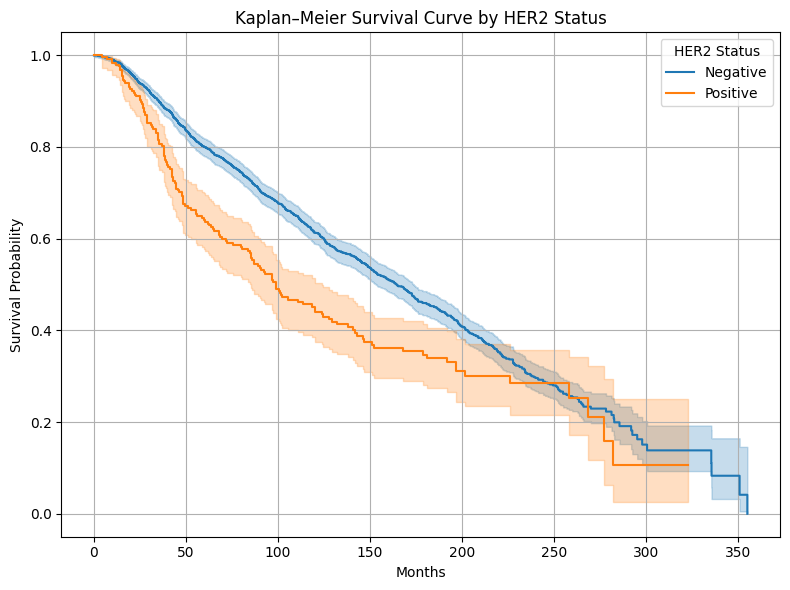

<lifelines.CoxPHFitter: fitted with 1459 total observations, 639 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1459
number of events observed = 820
   partial log-likelihood = -5246.82
         time fit was run = 2025-05-19 14:31:31 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
Age at Diagnosis      0.04      1.04      0.00            0.03            0.05                1.04                1.05
Tumor Size            0.01      1.01      0.00            0.00            0.01                1.00                1.01
Tumor Stage           0.33      1.39      0.07            0.20            0.46                1.22                1.58
ER Status_Positive   -0.14      0.87      0.11           -0.35            0.08                0.70                1.08
PR Status_Positive   -0.03      0.97      0.08           -0.20            0.13                0.82                1.14
HER2 Status_Positive  0.44      1.55      0.11            0.23            0.65                1.26                1.92
Chemotherapy_Yes      0.43      1.54      0.12            0.20            0.67                1.22                1.95
Radio Therapy_Yes    -0.19      0.83      0.08           -0.33           -0.04                0.72                0.96

                      cmp to     z      p  -log2(p)
covariate                                          
Age at Diagnosis        0.00 11.64 <0.005    101.54
Tumor Size              0.00  4.20 <0.005     15.22
Tumor Stage             0.00  4.91 <0.005     20.07
ER Status_Positive      0.00 -1.26   0.21      2.28
PR Status_Positive      0.00 -0.38   0.70      0.51
HER2 Status_Positive    0.00  4.08 <0.005     14.46
Chemotherapy_Yes        0.00  3.64 <0.005     11.86
Radio Therapy_Yes       0.00 -2.47   0.01      6.21
---
Concordance = 0.66
Partial AIC = 10509.64
log-likelihood ratio test = 298.02 on 8 df
-log2(p) of ll-ratio test = 195.88

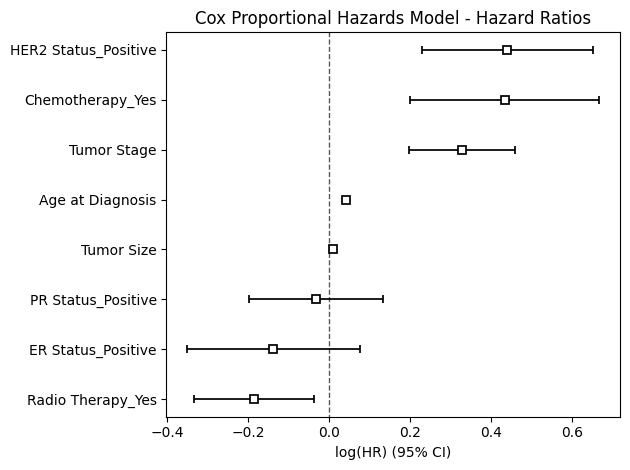

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter

# Load the dataset
df = pd.read_csv("metabric_clinical.csv")

# Convert survival status to binary: 1 = deceased, 0 = living
df['event'] = df['Overall Survival Status'].map({'Living': 0, 'Deceased': 1, 'Died of Disease': 1})

# Drop rows with missing survival time or event
df_surv = df[['Overall Survival (Months)', 'event']].dropna()
df_surv = df.loc[df_surv.index]

# ----------------------------
# Kaplan–Meier Curve Analysis
# ----------------------------
def plot_km_curve(group_col):
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(8, 6))
    for name, grouped_df in df_surv.groupby(group_col):
        kmf.fit(grouped_df['Overall Survival (Months)'], grouped_df['event'], label=str(name))
        kmf.plot_survival_function()
    plt.title(f"Kaplan–Meier Survival Curve by {group_col}")
    plt.xlabel("Months")
    plt.ylabel("Survival Probability")
    plt.legend(title=group_col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example for HER2 Status
plot_km_curve('HER2 Status')

# ----------------------------
# Cox Proportional Hazards Model
# ----------------------------
# Select covariates of interest
covariates = [
    'Age at Diagnosis', 'Tumor Size', 'Tumor Stage',
    'ER Status', 'PR Status', 'HER2 Status', 'Chemotherapy', 'Radio Therapy'
]

# Encode categorical variables
df_cox = df_surv[covariates + ['Overall Survival (Months)', 'event']].dropna()
df_cox = pd.get_dummies(df_cox, drop_first=True)

# Rename time and event columns
df_cox.rename(columns={'Overall Survival (Months)': 'duration'}, inplace=True)

# Fit the Cox model
cph = CoxPHFitter()
cph.fit(df_cox, duration_col='duration', event_col='event')

# Summary of the model
cph.print_summary()

# Plot the hazard ratios
cph.plot()
plt.title("Cox Proportional Hazards Model - Hazard Ratios")
plt.tight_layout()
plt.show()


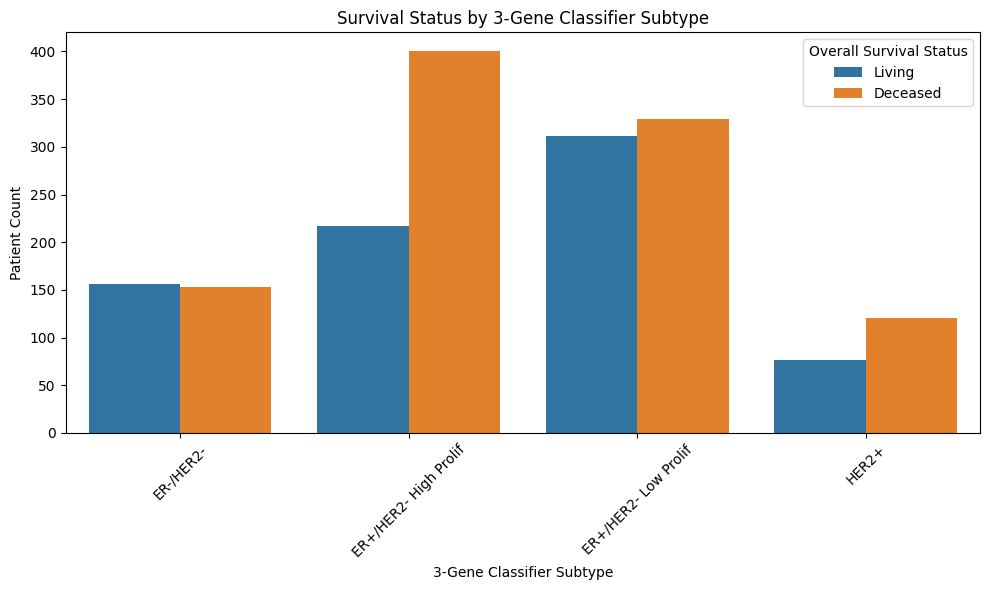

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("metabric_clinical.csv")

# Filter relevant columns
df_gene = df[['3-Gene classifier subtype', 'Overall Survival Status']].dropna()

# Countplot
plt.figure(figsize=(10, 6))
sns.countplot(data=df_gene, x='3-Gene classifier subtype', hue='Overall Survival Status')
plt.title("Survival Status by 3-Gene Classifier Subtype")
plt.xlabel("3-Gene Classifier Subtype")
plt.ylabel("Patient Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df_gene['3-Gene classifier subtype'], df_gene['Overall Survival Status'])

# Run chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared Test\nChi2: {chi2:.2f}, p-value: {p:.4f}")

if p < 0.05:
    print("→ Statistically significant association between gene subtype and survival status.")
else:
    print("→ No significant association found.")


Chi-squared Test
Chi2: 31.99, p-value: 0.0000
→ Statistically significant association between gene subtype and survival status.


In [ ]:
from lifelines import KaplanMeierFitter

# Prepare survival data
df['event'] = df['Overall Survival Status'].map({'Living': 0, 'Deceased': 1, 'Died of Disease': 1})
df_km = df[['3-Gene classifier subtype', 'Overall Survival (Months)', 'event']].dropna()

# Plot KM curves
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for subtype, subset in df_km.groupby('3-Gene classifier subtype'):
    kmf.fit(subset['Overall Survival (Months)'], subset['event'], label=subtype)
    kmf.plot_survival_function()

plt.title("Kaplan–Meier Curves by 3-Gene Classifier Subtype")
plt.xlabel("Overall Survival (Months)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'lifelines'

In [ ]:
from lifelines.statistics import logrank_test

# Example: compare ER+/HER2- High Prolif vs ER-/HER2-
group1 = df_km[df_km['3-Gene classifier subtype'] == 'ER+/HER2- High Prolif']
group2 = df_km[df_km['3-Gene classifier subtype'] == 'ER-/HER2-']

results = logrank_test(group1['Overall Survival (Months)'], group2['Overall Survival (Months)'],
                       event_observed_A=group1['event'], event_observed_B=group2['event'])

print(f"Log-rank test p-value: {results.p_value:.4f}")
if results.p_value < 0.05:
    print("→ Significant difference in survival curves.")
else:
    print("→ No significant difference in survival curves.")


Log-rank test p-value: 0.0108
→ Significant difference in survival curves.
